# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('../week6/test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [8]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [10]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [11]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [13]:
# specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [14]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [15]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $13.33 Truth: $13.99 Error: $0.66 SLE: 0.00 Item: GOLDTONE Brand Replacement Charcoal Wate...
2: Guess: $25.64 Truth: $9.98 Error: $15.66 SLE: 0.79 Item: Flngr 240530701 Pan Hanger (Right) for R...
3: Guess: $45.07 Truth: $944.26 Error: $899.19 SLE: 9.13 Item: Kenmore 20362 3.8 cu. ft. Top-Load Washe...
4: Guess: $45.43 Truth: $56.21 Error: $10.78 SLE: 0.04 Item: XiKe W10285625 Front Load Washer Tub Bea...
5: Guess: $23.51 Truth: $10.99 Error: $12.52 SLE: 0.51 Item: Lifetime Warranty W10837240 Dryer Idler ...
6: Guess: $33.34 Truth: $9.50 Error: $23.84 SLE: 1.40 Item: LaMi Products Economy Kitchen Accessory ...
7: Guess: $29.44 Truth: $18.74 Error: $10.70 SLE: 0.19 Item: Whirlpool W10258275 Bimetal Fuse for Dis...
8: Guess: $63.23 Truth: $32.54 Error: $30.69 SLE: 0.42 Item: Frigidaire 297259528 Start Device, White
9: Guess: $36.52 Truth: $27.76 Error: $8.76 SLE: 0.07 Item: Builder's Best CECOMINOD018526 J-Block D...
10: Guess: $186.67 Truth: $304.98 Error: $118.31 SLE: 0.24 I

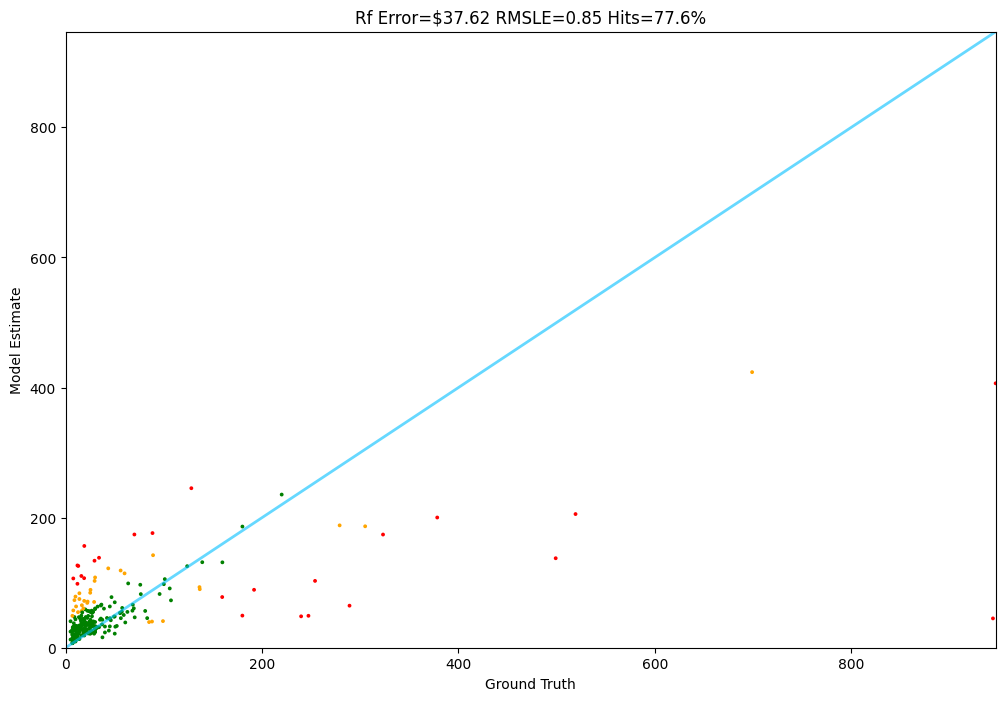

In [16]:
Tester.test(rf, test)

In [17]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [18]:
# print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

139.99
136.8904999999999


In [20]:
# specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    # specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

 27%|██▋       | 67/250 [01:11<03:14,  1.06s/it]


KeyboardInterrupt: 

In [19]:
mins = [min(f,r) for f,r in zip(frontiers, random_forests)]
maxes = [max(f,r) for f,r in zip(frontiers, random_forests)]
# mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
# maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    # 'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

NameError: name 'frontiers' is not defined

In [ ]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

In [ ]:
joblib.dump(lr, 'ensemble_model.pkl')

In [ ]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [ ]:
ensemble.price(product)

In [ ]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

In [ ]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.